In [54]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [3]:
pnc_path = r"C:\Users\willd\OneDrive\Desktop\Budget\statements\pnc_csvs"
chase_full = pd.read_csv(r"C:\Users\willd\OneDrive\Desktop\Budget\statements\Chase0818_Activity20221231_20231118_20231119.CSV")
pnc_full = pd.read_csv(r"C:\Users\willd\OneDrive\Desktop\Budget\statements\pnc_csvs\PNCaccountActivityExport.csv")

In [ ]:
# combine multiple pnc statements

In [4]:
# function to fill ammount column in the pnc dataframe 
def amount_fill(data):
    if '$' in str(data['Withdrawals']):
        amount = '-' + data['Withdrawals']
    else:
        amount = data['Deposits']
    return float(amount.replace('$', '').replace(',', ''))

In [5]:
pnc_full['Amount'] = pnc_full.apply(amount_fill, axis=1)

In [6]:
chase_full = chase_full.rename(columns={"Transaction Date": "Date"})

In [30]:
# add catacories to pnc data frame 
df = pnc_full['Description']
df2 = pnc_full['Amount']
cat_condition = [(df.str.contains('VENMO')) & (df2 > 0), (df.str.contains('VENMO')) & (df2 < 0), (df.str.contains('SPOTIFY') | df.str.contains('APPLE')),
                 (df.str.contains('ACTALENT')), (df.str.contains('CHECK'))
                , (df.str.contains('SCHWAB BROK'))]
cat_value = ['VENMO IN','VENMO OUT', 'SUBSCRIP', 'Belair', 'RENT', 'SCHWAB']
pnc_full['Category'] = np.select(cat_condition, cat_value)
# make a misc catagory of remaining  
pnc_full.loc[pnc_full['Category'] == '0', 'Category'] = 'Misc'

In [31]:
pnc_full

,Date,Description,Withdrawals,Deposits,Category,Balance,Amount
0,11/16/2023,ACH WEB XXXXX9263 CHASE CREDIT CRD EPAY,$361.88,NaN,Misc,$403.34,-361.88
1,11/15/2023,ONLINE TRANSFER TO XXXXX5748,$800.00,NaN,Misc,$765.22,-800.00
2,11/15/2023,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",NaN,"$1,188.79",Belair,"$1,565.22",1188.79
3,11/09/2023,ACH WEB XXXXX6175 VENMO PAY...,$320.82,NaN,VENMO OUT,$376.43,-320.82
4,11/09/2023,ACH WEB XXXXX8633 CHASE CREDIT CRD EPAY,$350.00,NaN,Misc,$697.25,-350.00
5,11/08/2023,ONLINE TRANSFER TO XXXXX5748,$500.00,NaN,Misc,"$1,047.25",-500.00
6,11/08/2023,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",NaN,"$1,188.78",Belair,"$1,547.25",1188.78
7,11/03/2023,CHECK 150 009542228,"$1,680.00",NaN,RENT,$358.47,-1680.00
8,11/02/2023,ACH WEB XXXXX5071 CHASE CREDIT CRD EPAY,$150.00,NaN,Misc,"$2,038.47",-150.00
9,11/01/2023,ONLINE TRANSFER TO XXXXX5748,"$1,000.00",NaN,Misc,"$2,188.47",-1000.00


In [32]:
import datetime

In [33]:
# Convert date columns to datetime and withdraw/depo to float
chase_full['Date'] = pd.to_datetime(chase_full['Date'])
pnc_full['Date'] = pd.to_datetime(pnc_full['Date'])

In [34]:
# reduce both data frames to relevant columns
chase_reduced = chase_full[["Date", 'Description', "Category", "Amount"]]
pnc_reduced = pnc_full[["Date", 'Description', "Category", "Amount"]]

In [35]:
# remove CC Payments from both 
pnc_no_cc = pnc_reduced[~pnc_reduced['Description'].str.contains('CHASE CREDIT CRD EPA')]
# remove pnc transfers 
pnc_no_transfer = pnc_no_cc[~pnc_no_cc['Description'].str.contains('ONLINE TRANSFER')]
chase_no_cc = chase_reduced[chase_reduced['Amount'] < 0]

In [36]:
# reduce to september 2023 on 
chase_sept = chase_no_cc[chase_no_cc['Date'] >= '2023-09-01']
pnc_sept = pnc_no_transfer[pnc_no_transfer['Date'] >= '2023-09-01']

In [38]:
# combine pnc and chase for analysis 
both = [chase_sept, pnc_sept]
full_df = pd.concat(both)

In [74]:
full_df['Month'] = pd.DatetimeIndex(full_df['Date']).month

In [75]:
money_in = full_df[full_df['Amount'] > 0]
money_out = full_df[full_df['Amount'] < 0]

In [76]:
money_in

,Date,Description,Category,Amount,Month
2,2023-11-15,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.79,11
6,2023-11-08,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.78,11
10,2023-11-01,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.79,11
13,2023-10-27,ACH CREDIT XXXXX5018 VENMO CAS...,VENMO IN,850.00,10
16,2023-10-25,NON-PNC ATM SURCHARGE REIMBURSEMENT,Misc,3.00,10
17,2023-10-25,ATM TRANSACTION FEE REIMBURSEMENT,Misc,3.00,10
18,2023-10-25,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.78,10
23,2023-10-18,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.79,10
26,2023-10-11,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.77,10
30,2023-10-04,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1228.64,10


In [79]:
expense_pivot = money_out.pivot_table(values='Amount', index='Category', columns='Month', aggfunc='sum')

In [80]:
expense_pivot

Month,9,10,11
Category,,,
Automotive,NaN,-122.52,NaN
Bills & Utilities,-89.39,-161.87,NaN
Entertainment,-929.00,NaN,NaN
Food & Drink,-601.67,-168.28,-99.19
Gas,-122.96,-127.90,-62.07
Groceries,-289.91,-128.29,-9.87
Health & Wellness,NaN,NaN,-179.70
Home,NaN,-23.82,NaN
Misc,-41.43,-146.78,NaN


In [56]:
import matplotlib.pyplot as plt

In [70]:
money_out['Amount'] = 0 - money_out['Amount']

C:\Users\willd\AppData\Local\Temp\ipykernel_9636\2362525790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_out['Amount'] = 0 - money_out['Amount']


In [73]:
ytd = money_in.loc[money_in['Category'] == 'Belair', 'Amount'].sum()
othermoney = money_in.loc[money_in['Category'] != 'Belair', 'Amount'].sum()
as_of = money_in['Date'].max()
expense = money_out['Amount'].sum() - othermoney
income_report = f"""
As of {as_of}, you have made a total of ${ytd}
And you have spent ${expense}"""
print(income_report)


As of 2023-11-15 00:00:00, you have made a total of $13151.24
And you have spent $10531.319999999998


ValueError: too many values to unpack (expected 2)

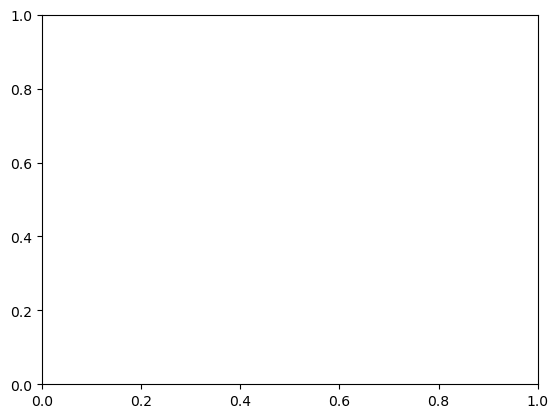